Running on device: cuda
Epoch 0, Loss: 12.935827, PDE: 0.050242, IC: 1.288559
Epoch 1000, Loss: 0.026689, PDE: 0.026559, IC: 0.000013
Epoch 2000, Loss: 0.022111, PDE: 0.022059, IC: 0.000005
Epoch 3000, Loss: 0.020413, PDE: 0.020369, IC: 0.000004
Epoch 4000, Loss: 0.019437, PDE: 0.019398, IC: 0.000004
Epoch 5000, Loss: 0.018336, PDE: 0.018311, IC: 0.000003
Epoch 6000, Loss: 0.016134, PDE: 0.015516, IC: 0.000062
Epoch 7000, Loss: 0.003505, PDE: 0.003256, IC: 0.000025
Epoch 8000, Loss: 0.000647, PDE: 0.000646, IC: 0.000000
Epoch 9000, Loss: 0.000478, PDE: 0.000421, IC: 0.000006
Training finished in 88.31 seconds.


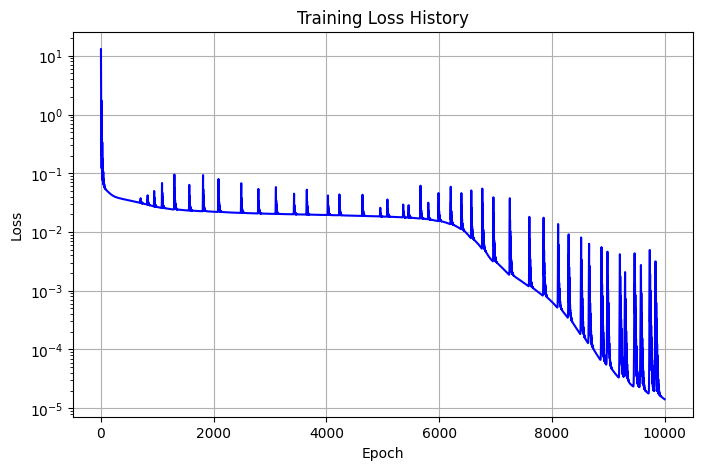

Mean Squared Error: 1.741724e-05


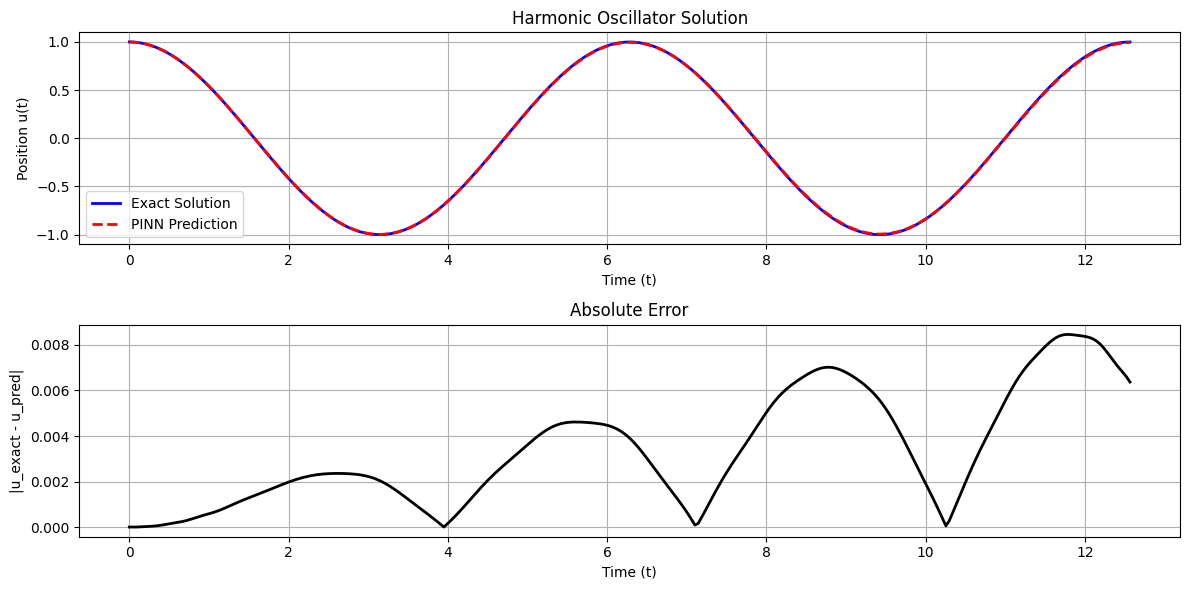

interactive(children=(FloatSlider(value=0.0, description='time_val', max=12.566370614359172, step=0.01), Outpu…

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, FloatSlider
import time

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on device:", device)

def exact_solution(t):
    """
    Harmonic oscillator exact solution for d^2u/dt^2 + omega^2*u = 0
    with initial conditions u(0)=1, u'(0)=0 => u(t)=cos(omega*t).
    """
    omega = 1.0
    return np.cos(omega * t)

class PINN(nn.Module):
    """
    A fully-connected neural network for approximating the harmonic oscillator solution.
    """
    def __init__(self, hidden_dim=128):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, t):
        """
        Forward pass: t is a tensor of shape (N, 1).
        Returns u(t) of shape (N, 1).
        """
        return self.net(t)

def physics_residual(model, t):
    """
    Computes the PDE residual: d^2u/dt^2 + omega^2 * u = 0.
    """
    # Require gradient on t so we can compute derivatives
    t = t.clone().detach().requires_grad_(True)
    u = model(t)

    # First derivative du/dt
    du_dt = torch.autograd.grad(
        outputs=u,
        inputs=t,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

    # Second derivative d^2u/dt^2
    d2u_dt2 = torch.autograd.grad(
        outputs=du_dt,
        inputs=t,
        grad_outputs=torch.ones_like(du_dt),
        create_graph=True
    )[0]

    # Harmonic oscillator PDE
    omega = 1.0
    return d2u_dt2 + (omega**2) * u

def train_pinn(model, t0, u0, du0, t_colloc, epochs=10000, lr=1e-3, physics_weight=1.0):
    """
    Trains the PINN by combining PDE residual loss and initial condition losses.
    """
    start_time = time.time()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1000, factor=0.5, verbose=True)
    mse = nn.MSELoss()

    # Move data to the chosen device
    t_colloc = t_colloc.view(-1,1).to(device)
    t0 = t0.view(-1,1).to(device)
    u0 = u0.view(-1,1).to(device)
    du0 = du0.view(-1,1).to(device)

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # PDE residual for collocation points
        res = physics_residual(model, t_colloc)
        pde_loss = torch.mean(res**2)

        # Enforce initial conditions: u(0)=1, u'(0)=0
        u_pred0 = model(t0)
        ic_pos_loss = mse(u_pred0, u0)

        t0_req = t0.clone().detach().requires_grad_(True)
        u_ic = model(t0_req)
        du_dt0 = torch.autograd.grad(
            outputs=u_ic,
            inputs=t0_req,
            grad_outputs=torch.ones_like(u_ic),
            create_graph=True
        )[0]
        ic_vel_loss = mse(du_dt0, du0)

        # Combine PDE loss and IC loss
        loss = physics_weight * pde_loss + 10.0 * (ic_pos_loss + ic_vel_loss)

        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        losses.append(loss.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}, PDE: {pde_loss.item():.6f}, IC: {(ic_pos_loss.item() + ic_vel_loss.item()):.6f}")

    training_time = time.time() - start_time
    print(f"Training finished in {training_time:.2f} seconds.")

    # Plot the training loss
    plt.figure(figsize=(8,5))
    plt.plot(losses, 'b-')
    plt.yscale('log')
    plt.title('Training Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def plot_results(model, t_domain):
    """
    Provides 2D plots, interactive slider, and a 3D plot to visualize results.
    """
    t_vals = np.linspace(t_domain[0], t_domain[1], 300)
    u_exact = exact_solution(t_vals)

    t_tensor = torch.tensor(t_vals, dtype=torch.float32).view(-1,1).to(device)
    with torch.no_grad():
        u_pred = model(t_tensor).cpu().numpy().flatten()

    error = np.abs(u_exact - u_pred)
    mse = np.mean(error**2)
    print(f"Mean Squared Error: {mse:.6e}")

    # 2D line plot: exact vs predicted
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plt.plot(t_vals, u_exact, 'b-', label='Exact Solution', linewidth=2)
    plt.plot(t_vals, u_pred, 'r--', label='PINN Prediction', linewidth=2)
    plt.title('Harmonic Oscillator Solution')
    plt.xlabel('Time (t)')
    plt.ylabel('Position u(t)')
    plt.grid(True)
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(t_vals, error, 'k-', linewidth=2)
    plt.title('Absolute Error')
    plt.xlabel('Time (t)')
    plt.ylabel('|u_exact - u_pred|')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Interactive slider
    def slider_plot(time_val):
        idx = (np.abs(t_vals - time_val)).argmin()
        print(f"t={t_vals[idx]:.3f}, exact={u_exact[idx]:.4f}, pred={u_pred[idx]:.4f}, err={error[idx]:.4f}")
        plt.figure(figsize=(5,4))
        plt.bar(['Exact','Pred'], [u_exact[idx], u_pred[idx]], color=['blue','red'])
        plt.title(f'u(t) at t={t_vals[idx]:.3f}')
        plt.ylim([min(u_exact[idx],u_pred[idx])-0.1, max(u_exact[idx],u_pred[idx])+0.1])
        plt.show()

    interact(slider_plot, time_val=FloatSlider(min=t_domain[0], max=t_domain[1], step=0.01, value=0.0))

    # 3D line plot using Plotly
    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'type':'scatter3d'}, {'type':'scatter3d'}]],
                        subplot_titles=('Exact/Pred vs Time','Error vs Time'))

    fig.add_trace(go.Scatter3d(
        x=t_vals,
        y=u_exact,
        z=[0]*len(t_vals),
        mode='lines',
        name='Exact',
        line=dict(color='blue')
    ), row=1, col=1)

    fig.add_trace(go.Scatter3d(
        x=t_vals,
        y=u_pred,
        z=[0]*len(t_vals),
        mode='lines',
        name='Pred',
        line=dict(color='red')
    ), row=1, col=1)

    fig.add_trace(go.Scatter3d(
        x=t_vals,
        y=error,
        z=[0]*len(t_vals),
        mode='lines',
        name='Error',
        line=dict(color='black')
    ), row=1, col=2)

    fig.update_layout(
        title='3D Plots for Harmonic Oscillator',
        scene=dict(
            xaxis_title='Time (t)',
            yaxis_title='Value',
            zaxis_title='(dummy=0)'
        ),
        autosize=False,
        width=1100,
        height=500
    )
    fig.show()

if __name__ == "__main__":
    # Time domain
    t_domain = [0.0, 4.0*np.pi]

    # Collocation points for PDE
    t_colloc = torch.linspace(t_domain[0], t_domain[1], 3000)

    # Initial conditions
    t0 = torch.tensor([0.0], dtype=torch.float32)
    u0 = torch.tensor([1.0], dtype=torch.float32)
    du0 = torch.tensor([0.0], dtype=torch.float32)

    # Create and train the model
    model = PINN(hidden_dim=128).to(device)
    train_pinn(model, t0, u0, du0, t_colloc, epochs=10000, lr=1e-3, physics_weight=1.0)

    # Plot and evaluate
    plot_results(model, t_domain)

    # Save the trained model
    torch.save(model.state_dict(), 'harmonic_oscillator_pinn.pth')
